# Statistical quality control



This Jupyter notebooks shows some Python code for calculating sample plans for statistical quality control.

See also the [Statistical quality control webapp](https://a-herzog.github.io/QC/).

## Preparation and utility functions

### Importing libraries

In [80]:
from math import floor, ceil, factorial, exp
from scipy.special import binom
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections.abc import Callable

plt.style.use('seaborn-v0_8')

### Plotting operation characteristics

In [81]:
def plot_L(L: Callable[[float], float], title: str, N: float | None = None, n: float | None = None, AQL: tuple[float, float] | None = None, LQ: tuple[float, float] | None = None, steepness: tuple[float, float] | None = None) -> None:
    """Plots the operation characteristics function

    Args:
        L (Callable[[float], float]): Operation characteristics function
        title (str): Title of the plot,
        N (float | None, optional): Number of items in the lot. Defaults to None.
        n (float | None, optional): Number of items in the sample. Defaults to None.
        AQL (tuple[float, float] | None, optional): AQL. Defaults to None.
        LQ (tuple[float, float] | None, optional): LQ. Defaults to None.
        steepness (tuple[float, float] | None, optional): Point of indifference and steepness at this point. Defaults to None.
    """
    p = np.linspace(0, 0.5, 100)
    L_values = np.vectorize(L)(p)
    slip_through_values = L_values * p

    lns1 = plt.plot(p, L_values, color='blue', label='Acceptance probability')
    lns2 = plt.plot(p, slip_through_values, color='magenta', linestyle='dashed', label='Average slip through')

    plt.title(title)
    plt.xlabel("Defect rate")
    plt.ylabel("Acceptance probability / Slip through")
    plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))

    if AQL is not None and LQ is not None:
        points = tuple(zip(AQL, LQ))
        plt.scatter(points[0], points[1], color=['green', 'red'])

    if steepness is not None:
        p50percent = steepness[0]
        h0 = steepness[1]
        plt.scatter([p50percent], [0.5], color=['red'])
        dL = -h0 / 2 / p50percent
        x = np.linspace(max(0, p50percent - 0.025), min(0.5, p50percent + 0.025))
        y = 0.5 + (x - p50percent) * dL
        plt.plot(x, y, color='red')

    if N is not None and n is not None:
        testing_effort = n * L_values + N * (1 - L_values)
        ax2 = plt.twinx()
        lns3 = ax2.plot(p[0:len(p) * 2 // 3], testing_effort[0:len(p) * 2 // 3], color='green', linestyle='dotted', label='Average testing effort')  # pyright: ignore[reportAttributeAccessIssue]
        ax2.set_ylabel("Average testing effort")
        ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

        lns = lns1 + lns2 + lns3
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, loc=0)
    else:
        plt.legend(loc=0)

### Testing AQL and LQ

In [82]:
def test_AQL(L: Callable[[float], float], AQL: tuple[float, float]) -> bool:
    """Tests whether the operation characteristics fulfills the AQL

    Args:
        L (Callable[[float], float]): Operation characteristics function
        AQL (tuple[float, float]): AQL

    Returns:
        bool: Returns true if the operation characteristics fulfulls the AQL
    """
    return L(AQL[0]) >= AQL[1]

def test_LQ(L: Callable[[float], float], LQ: tuple[float, float]) -> float:
    """Tests whether the operation characteristics fulfills the LQ

    Args:
        L (Callable[[float], float]): Operation characteristics function
        LQ (tuple[float, float]): LQ

    Returns:
        bool: Returns true if the operation characteristics fulfulls the LQ
    """
    return L(LQ[0]) <= LQ[1]

def test_plan(L: Callable[[float], float], AQL: tuple[float, float], LQ: tuple[float, float]) -> float:
    """Tests whether the operation characteristics fulfills the AQL and the LQ

    Args:
        L (Callable[[float], float]): Operation characteristics function
        AQL (tuple[float, float]): AQL
        LQ (tuple[float, float]): LQ

    Returns:
        bool: Returns true if the operation characteristics fulfulls the AQL and the LQ
    """
    return test_AQL(L, AQL) and test_LQ(L, LQ)

### Operation characteristics function with different distributions

In [83]:
def L_Hg(N: int, n: int, c: int, p: float) -> float:
    """Operation characteristics function when using the hypergeometric distribution to model the sampling process

    Args:
        N (int): Size of delivery
        n (int): Sample size
        c (int): Maximum allowed number of defects
        p (float): Defect rate

    Returns:
        float: Acceptance probability
    """
    R = floor(N * p)
    return np.sum([binom(R, k) * binom(N - R, n - k) / binom(N, n) for k in range(c + 1)])


def L_B(n: int, c: int, p: float) -> float:
    """Operation characteristics function when using the binomial distribution to model the sampling process

    Args:
        n (int): Sample size
        c (int): Maximum allowed number of defects
        p (float): Defect rate

    Returns:
        float: Acceptance probability
    """
    return np.sum([binom(n, k)*p**k*(1-p)**(n-k) for k in range(c + 1)])


def L_P(n: int, c: int, p: float) -> float:
    """Operation characteristics function when using the Poisson distribution to model the sampling process

    Args:
        n (int): Sample size
        c (int): Maximum allowed number of defects
        p (float): Defect rate

    Returns:
        float: Acceptance probability
    """
    lmbda = n * p
    return np.sum([lmbda**k / factorial(k) * exp(-lmbda) for k in range(c + 1)])

## Plotting an operation characteristics

True

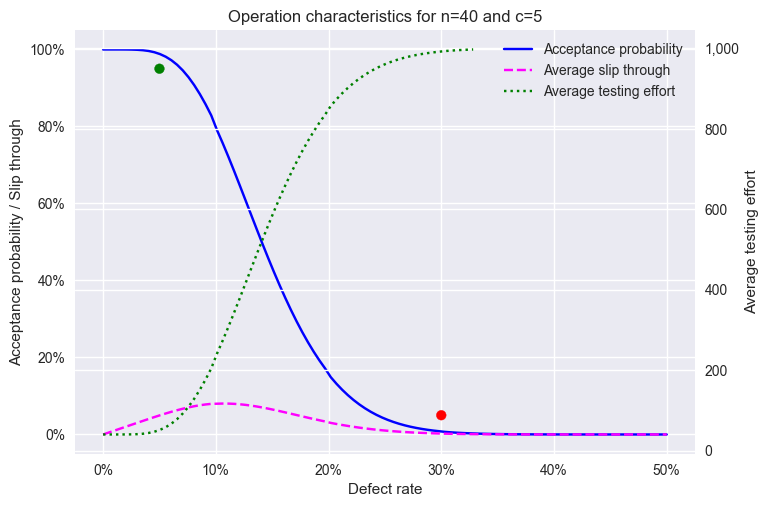

In [84]:
# Size of delivery
N = 1000

# Good and bad limits
AQL = (0.05, 0.95)  # Deliveries with a maximum of 5% defect parts should be accepted with at least 95% probability.
LQ = (0.3, 0.05)  # Deliveries with 30% or more defect parts should be accepted with a maximum probability of 5%.

# Sample plan
n = 40
c = 5

# Operation characteristics function
def L(p): return L_Hg(N, n, c, p)

# Plot operation characteristics
plot_L(L, f"Operation characteristics for n={n} and c={c}", N, n, AQL, LQ)

# Does the sample plan fulfill AQL and LQ?
test_plan(L, AQL, LQ)

## Algorithm from Günther

Optimal plan found: n = 24 , c = 3


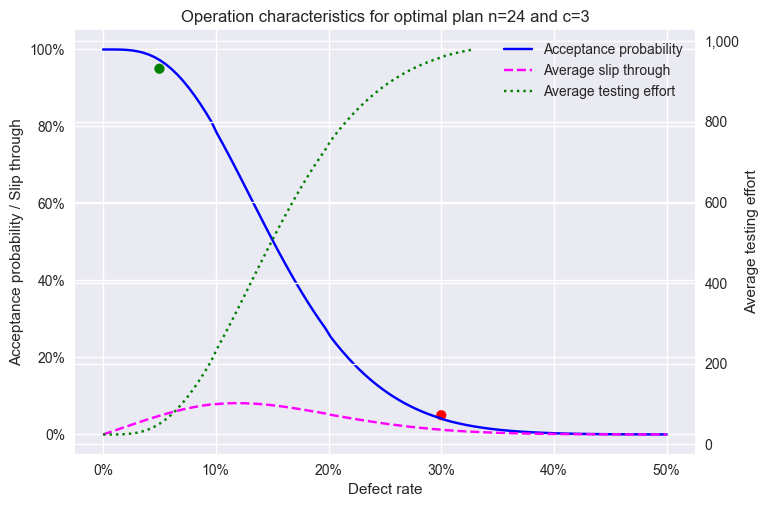

In [85]:
# Size of delivery
N = 1000

# Good and bad limits
AQL = (0.05, 0.95)  # Deliveries with a maximum of 5% defect parts should be accepted with at least 95% probability.
LQ = (0.3, 0.05)  # Deliveries with 30% or more defect parts should be accepted with a maximum probability of 5%.

# Initial sample plan
n = 1
c = 0

# Does the initial sample plan already fulfill AQL and LQ?
done = False
if test_plan(lambda p: L_Hg(N, n, c, p), AQL, LQ):
    print("Optimal plan found: n =", n, ", c =", c)
    done = True

# Outer loop: Iterate over c
if not done:
    while True:
        # Inner loop: Iterate over n
        while not test_LQ(lambda p: L_Hg(N, n, c, p), LQ):
            n += 1
        if test_AQL(lambda p: L_Hg(N, n, c, p), AQL):
            print("Optimal plan found: n =", n, ", c =", c)
            break
        c += 1
        n = c

# Plot operation characteristics for optimal sample plan
plot_L(lambda p: L_Hg(N, n, c, p), f"Operation characteristics for optimal plan n={n} and c={c}", N, n, AQL, LQ)

## $\chi^2$ method

Optimal plan found: n = 26 , c = 3


True

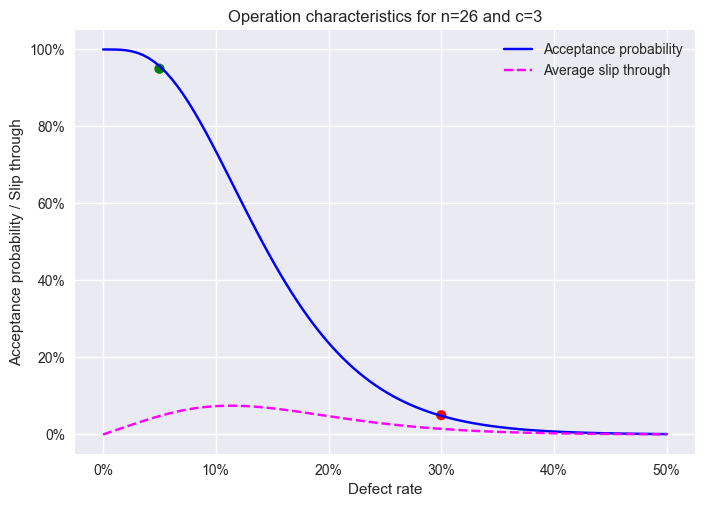

In [86]:
# Good and bad limits
AQL = (0.05, 0.95)  # Deliveries with a maximum of 5% defect parts should be accepted with at least 95% probability.
LQ = (0.3, 0.05)  # Deliveries with 30% or more defect parts should be accepted with a maximum probability of 5%.

c = 0
while True:
    n = ceil(chi2.ppf(1 - LQ[1], 2 * (c + 1)) / (2 * LQ[0]))
    n2 = floor(chi2.ppf(1 - AQL[1], 2 * (c + 1)) / (2 * AQL[0]))
    if n <= n2:
        print("Optimal plan found: n =", n, ", c =", c)
        break
    c += 1

# Operation characteristics function
def L(p): return L_P(n, c, p)

# Plot operation characteristics
plot_L(L, f"Operation characteristics for n={n} and c={c}", AQL=AQL, LQ=LQ)

# Does the sample plan fulfill AQL and LQ?
test_plan(L, AQL, LQ)

## Philips sampling plan

Optimal plan found: n = 67 , c = 6


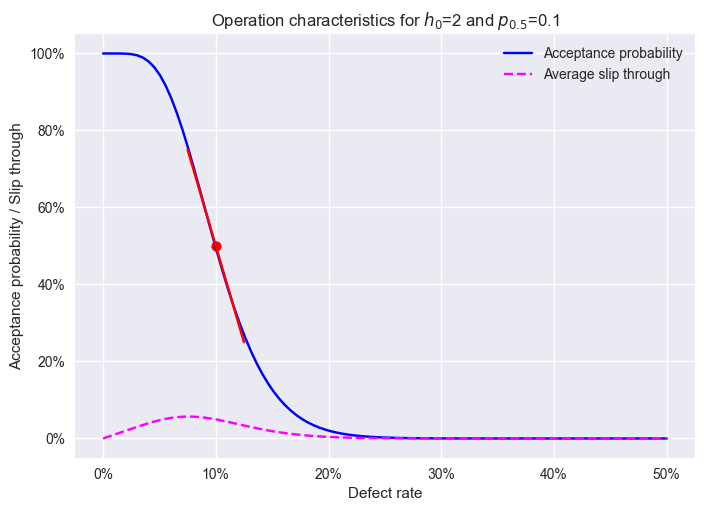

In [87]:
# Steepness at the point of indifference
h0 = 2

# Point of indifference
p50percent = 0.1

c = 0
while True:
    n = ceil(chi2.ppf(0.5, 2 * (c + 1)) / (2 * p50percent))
    if 2 * (n * p50percent)**(c + 1) / factorial(c) * exp(-n * p50percent) >= h0:
        print("Optimal plan found: n =", n, ", c =", c)
        break
    c += 1

# Operation characteristics function
def L(p): return L_P(n, c, p)

# Plot operation characteristics
plot_L(L, f"Operation characteristics for $h_0$={h0} and $p_{{0.5}}$={p50percent}", steepness=(p50percent, h0))